In [1]:
from qmratool.models import *
import pymc3 as pm
import plotly.express as px
import arviz as az
import numpy as np
import pandas as  pd
import plotly.express as px
from plotly.offline import plot
from django_pandas.io import read_frame
import decimal


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
y = pm.Normal.dist(mu=10, sigma=5)

In [3]:
fig = px.histogram(x = y.random(size=10000))
fig.show()

In [4]:
with pm.Model() as model:

    x = pm.Normal('x', mu=0, sigma=1)

In [5]:
x.random(size = 100)

array([ 6.84278426e-01, -8.10343251e-01,  1.96795072e-01, -3.89977782e-01,
        1.38670263e+00,  2.16899066e+00, -1.38768064e+00, -4.08458032e-01,
       -7.42492731e-01,  9.38349502e-01, -4.21622898e-01,  3.30068682e-01,
       -9.34038313e-01, -8.80656130e-01, -1.00562118e+00, -6.55151235e-02,
        1.11873505e+00, -2.70478653e+00,  5.26167165e-01,  1.70979210e+00,
       -1.76689913e+00, -2.05223605e-01,  9.14506632e-01, -1.58045854e-01,
        8.17514699e-02,  1.43656055e+00,  5.79389139e-01, -1.16662480e-01,
        1.33503203e+00,  7.21157334e-01, -9.55120608e-01, -9.41419418e-01,
        6.24606883e-01, -2.50715904e+00, -1.22498220e+00,  3.68708435e-01,
        2.57991308e-01, -8.32808923e-02, -5.70060328e-01,  2.69411201e+00,
       -2.88710461e-04, -9.56363522e-02, -9.60728605e-01,  4.95268092e-01,
       -1.43601808e+00, -2.02920070e-01,  3.32393527e-01, -1.50954711e+00,
       -1.23187944e+00,  1.20624121e+00, -8.18153692e-01,  8.22817458e-01,
       -1.78996718e-01, -

In [6]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=4, sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=1, observed=x.random(size = 100))

    idata = pm.sample(2000, tune=1500, return_inferencedata=True)



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_500 tune and 2_000 draw iterations (6_000 + 8_000 draws total) took 3 seconds.
The acceptance probability does not match the target. It is 0.7203689060071977, but should be close to 0.8. Try to increase the number of tuning steps.


In [7]:
idata.posterior.dims

Frozen(SortedKeysDict({'chain': 4, 'draw': 2000}))

array([[<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>]], dtype=object)

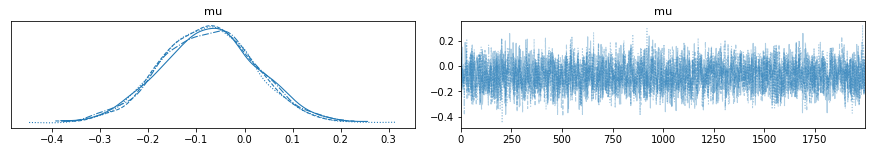

In [8]:
az.plot_trace(idata)

In [9]:
az.summary(idata)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu -0.076  0.099  -0.264    0.105      0.002    0.001    3406.0    5222.0   

    r_hat  
mu    1.0

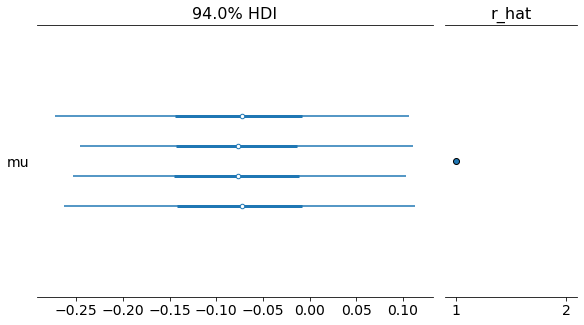

In [10]:
az.plot_forest(idata, r_hat=True);

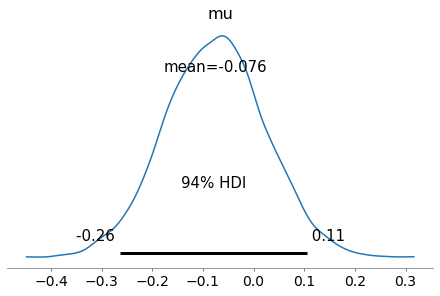

In [11]:
az.plot_posterior(idata);


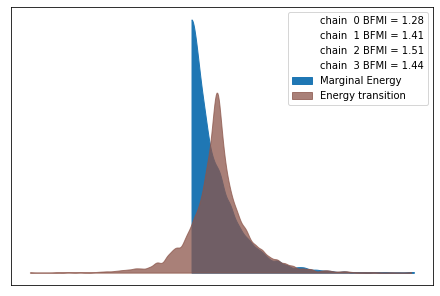

In [12]:
az.plot_energy(idata);

In [13]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    sd = pm.HalfNormal("sd", sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=sd, observed=x.random(size=100))

    approx = pm.fit()

Finished [100%]: Average Loss = 151.91


In [15]:
ra = RiskAssessment.objects.get(name = "El Port de la Selva")

In [17]:
# Selecting inflow concentration based in source water type
df_inflow = read_frame(Inflow.objects.filter(water_source=ra.source).values("min", "max", "pathogen__pathogen", "water_source__water_source_name"))


In [21]:
# Querying dose response parameters based on pathogen inflow
dr_models = read_frame(DoseResponse.objects.filter(pathogen__in=Pathogen.objects.filter(pathogen__in=df_inflow["pathogen__pathogen"])))


In [25]:
# Querying for Logremoval based on selected treatments
df_treatment=read_frame(LogRemoval.objects.filter(treatment__in=ra.treatment.all()).values("min", "max", "treatment__name", "pathogen_group__pathogen_group"))


In [28]:
# Summarizing treatment to treatment max and treatment min
df_treatment_summary=df_treatment.groupby(["pathogen_group__pathogen_group"]).sum().reset_index()
   

In [31]:
def annual_risk(nexposure, event_probs):
    return 1-np.prod(1-np.random.choice(event_probs, nexposure, True))


In [42]:
for index, row in df_inflow.iterrows():
    print(row)

min                                     0.10000000
max                                  1000.00000000
pathogen__pathogen                       Rotavirus
water_source__water_source_name    sewage, treated
Name: 0, dtype: object
min                                          0.00100000
max                                       1000.00000000
pathogen__pathogen                 Campylobacter jejuni
water_source__water_source_name         sewage, treated
Name: 1, dtype: object
min                                            0.01000000
max                                        10000.00000000
pathogen__pathogen                 Cryptosporidium parvum
water_source__water_source_name           sewage, treated
Name: 2, dtype: object


In [44]:
df_inflow.loc[df_inflow["pathogen__pathogen"] == "Rotavirus"]

min            max pathogen__pathogen  \
0  0.10000000  1000.00000000          Rotavirus   

  water_source__water_source_name  
0                 sewage, treated

In [148]:
results = pd.DataFrame()

for index, row in df_inflow.iterrows():
    d = df_inflow.loc[df_inflow["pathogen__pathogen"] ==row["pathogen__pathogen"]]
    dr = dr_models.loc[dr_models["pathogen"]==row["pathogen__pathogen"]]

    if row["pathogen__pathogen"] == "Rotavirus":
        selector = "Viruses" 
    elif row["pathogen__pathogen"]== "Cryptosporidium parvum":
        selector = "Protozoa"
    else:
        selector = "Bacteria"
    #result.append(selector)

    df_treat = df_treatment_summary[df_treatment_summary["pathogen_group__pathogen_group"]==selector]



    risk_df = pd.DataFrame({"inflow": np.random.normal(loc=(np.log10(float(d["min"])+10**(-8))+np.log10(float(d["max"]) ))/2, 
                                                        scale = (np.log10(float(d["max"]))-np.log10(float(d["min"])+10**(-8) ))/4,  
                                                        size = 10000),
                            "LRV": np.random.uniform(low= df_treat["min"], 
                                                     high= df_treat["max"], 
                                                     size= 10000) })
    risk_df["outflow"]=risk_df["inflow"] - risk_df["LRV"]
    risk_df["dose"] = (10**risk_df["outflow"])*float(ra.exposure.volume_per_event)

    if selector != "Protozoa":
        risk_df["probs"] = 1 - (1 + (risk_df["dose"]) * (2 ** (1/float(dr.alpha)) - 1)/float(dr.n50)) ** -float(dr.alpha)
    else:
        risk_df["probs"] = 1 - np.exp(-float(dr.k)*(risk_df["dose"]))

    results[row["pathogen__pathogen"]] = [annual_risk(int(ra.exposure.events_per_year), risk_df["probs"] ) for _ in range(1000)]


In [58]:
results_long = pd.melt(results)
results_long["log probability"] = np.log10(results_long["value"])

In [60]:
results_long

variable     value  log probability
0                  Rotavirus  0.999871        -0.000056
1                  Rotavirus  0.999836        -0.000071
2                  Rotavirus  0.999982        -0.000008
3                  Rotavirus  0.999988        -0.000005
4                  Rotavirus  0.999964        -0.000016
...                      ...       ...              ...
2995  Cryptosporidium parvum  0.471600        -0.326427
2996  Cryptosporidium parvum  0.999791        -0.000091
2997  Cryptosporidium parvum  0.405895        -0.391587
2998  Cryptosporidium parvum  0.634631        -0.197479
2999  Cryptosporidium parvum  0.727912        -0.137921

[3000 rows x 3 columns]

In [75]:


fig = px.box(results_long, x="variable", y="value",
                            points="all",  log_y =True, 
                            title="Risk as probability of infection per year",
                            color_discrete_sequence=["#007c9f", "#007c9f", "#007c9f"])

#fig.update_layout(shapes=[
#dict(
#  type= 'line',
#  y0= 0.03, y1= 0.03,
#  x0 =-.5, x1=2.5,
#  line=dict(
#    color="MediumPurple",
#    width=4,
#    dash="dot") 
#)
#])

fig.update_layout(
    font_family="Helvetica Neue, Helvetica, Arial, sans-serif",
    font_color="black",
    title = {'text':'Risk assessment as probability of infection per year'},
    xaxis_title = "Reference Pathogen",
    yaxis_title = "Probability of infection per year",
    #markersize= 12,
    )

fig.update_traces(marker_size = 8)#['#75c3ff', "red"],#, marker_line_color='#212c52',


fig.show()


In [84]:


fig = px.histogram(results_long, x="value", color = "variable",
                           #log_x =True, 
                            title="Risk as probability of infection per year",
                            color_discrete_sequence=["red", "#007c9f", "green"])


fig.update_layout(
    font_family="Helvetica Neue, Helvetica, Arial, sans-serif",
    font_color="black",
    title = {'text':'Risk assessment as probability of infection per year'},
    xaxis_title = "Reference Pathogen",
    yaxis_title = "Probability of infection per year",
    #markersize= 12,
    )



fig.show()

In [144]:
 # reshaping dataframe for plotting
df_inflow2 = pd.melt(df_inflow, ("pathogen__pathogen", "water_source__water_source_name"))
df_inflow2 = df_inflow2[df_inflow2.pathogen__pathogen.isin(["Rotavirus", "Cryptosporidium parvum", "Campylobacter jejuni"])]
df_inflow2 = df_inflow2.rename(columns={"pathogen__pathogen": "Pathogen", "variable":""})

In [147]:
fig = px.bar(df_inflow2, 
             x="", y = "value", 
             log_y=True,
            facet_col="Pathogen", 
            barmode="group", 
            color_discrete_sequence=["#007c9f", "rgb(0, 86, 100)", "grey", "red3", "steelblue"])

              
fig.update_layout(
    font_family="Helvetica Neue, Helvetica, Arial, sans-serif",
    font_color="black",
    title = {'text':'Inflow concentrations of referene pathogens'},
    yaxis_title = "Source water concentraitons in N/L",
    )
              

fig.show()
             

In [116]:
# reshaping     
df = pd.melt(df_treatment, ("treatment__name", "pathogen_group__pathogen_group"))


In [123]:
df = df.rename(columns = {"treatment__name": "Treatment", "pathogen_group__pathogen_group": "Pathogen Group", "variable":""})

In [124]:
df

Treatment Pathogen Group      value
0   Conventional clarification       Bacteria  min   0.2
1   Conventional clarification        Viruses  min   0.1
2   Conventional clarification       Protozoa  min   1.0
3             Chlorine dioxide       Bacteria  min   2.0
4             Chlorine dioxide        Viruses  min   2.0
5             Chlorine dioxide       Protozoa  min   2.0
6          Secondary treatment       Bacteria  min   0.0
7          Secondary treatment        Viruses  min   0.0
8          Secondary treatment       Protozoa  min   0.0
9    Wetlands, subsurface flow       Bacteria  min   1.5
10   Wetlands, subsurface flow       Protozoa  min   0.5
11  Conventional clarification       Bacteria  max   2.0
12  Conventional clarification        Viruses  max   3.4
13  Conventional clarification       Protozoa  max   2.0
14            Chlorine dioxide       Bacteria  max   2.0
15            Chlorine dioxide        Viruses  max   2.0
16            Chlorine dioxide       Protozoa  max   2.0
17         Secondary treatment       Bacteria  max   0.5
18         Secondary treatment        Viruses  max   0.1
19         Secondary treatment       Protozoa  max   1.0
20   Wetlands, subsurface flow       Bacteria  max   2.5
21   Wetlands, subsurface flow       Protozoa  max   1.5

In [140]:

fig = px.bar(df, x="", y = "value", 
color="Treatment", facet_col="Pathogen Group",
color_discrete_sequence=["#007c9f", "rgb(0, 86, 100)", "grey"])
#title="Log-removal of selected treatment train")
fig.update_layout(legend=dict(
                 orientation="h",
                 yanchor="top",
                 y=-.1,
                 xanchor="left",
                x=0))

fig.update_layout(
    font_family="Helvetica Neue, Helvetica, Arial, sans-serif",
    font_color="black",
    title = {'text':'Inflow concentrations of referene pathogens'},
    
    yaxis_title = "Logremoval of individual treatment step",
    )




fig.show()

In [41]:
X = 10

In [42]:
Y=10

In [44]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np

In [45]:
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [46]:
# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0] * X1 + beta[1] * X2 + np.random.randn(size) * sigma

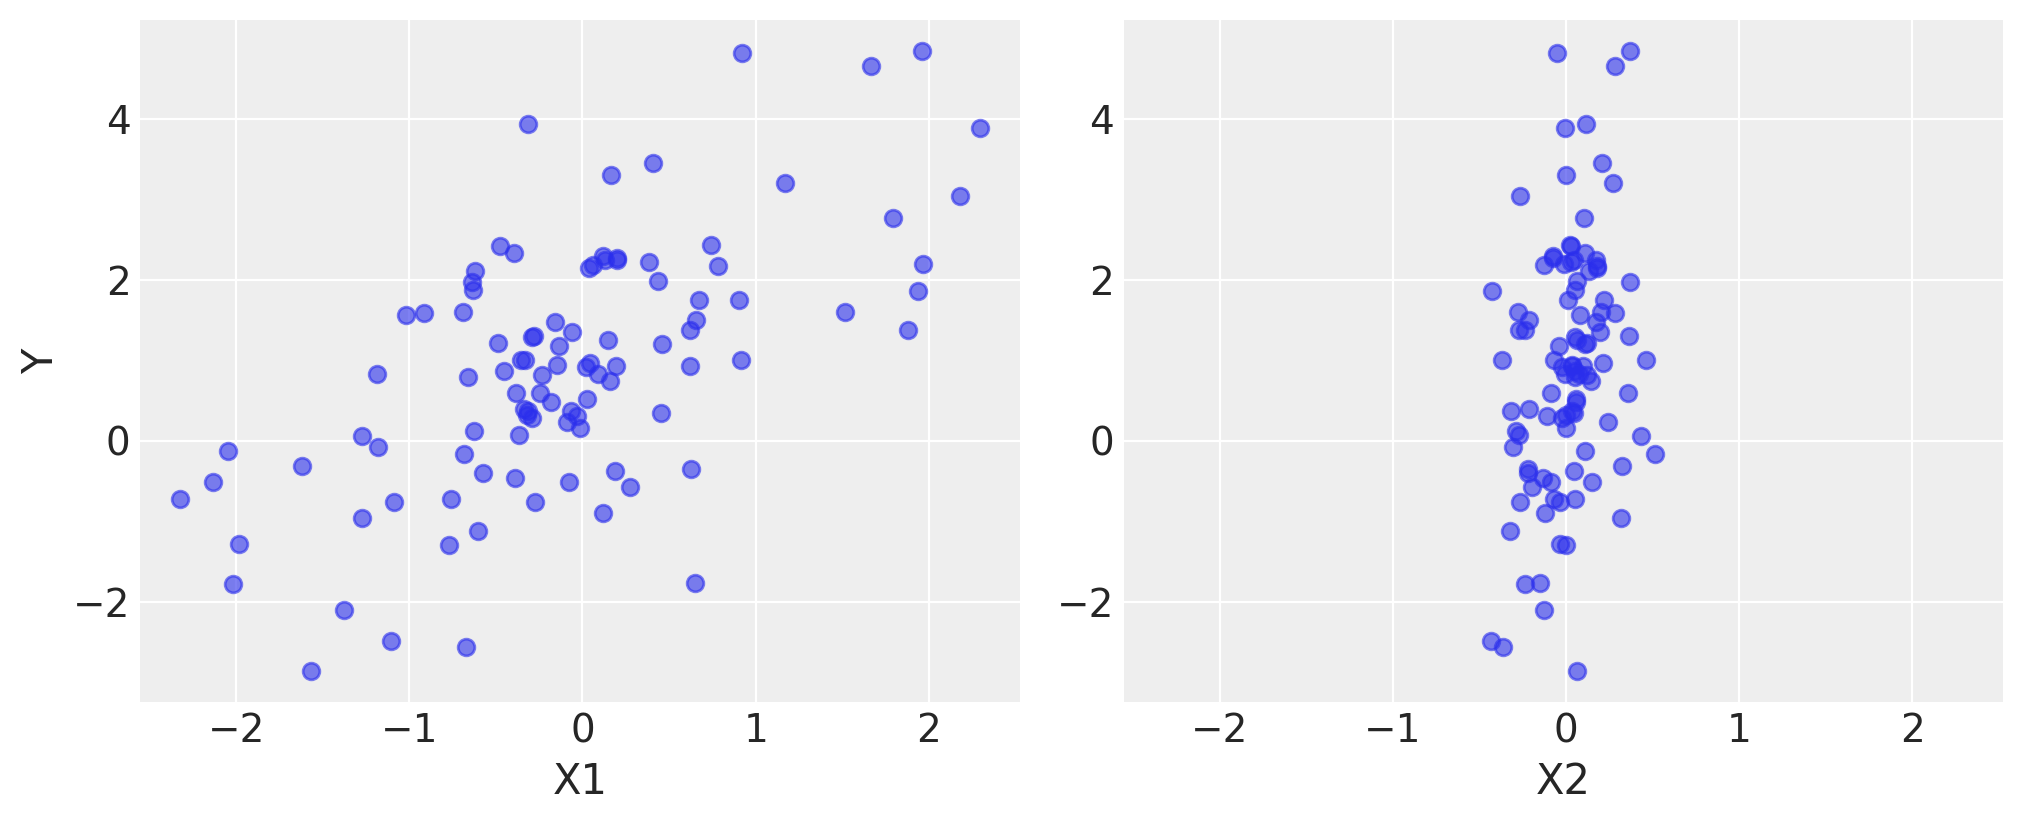

In [47]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10, 4))
axes[0].scatter(X1, Y, alpha=0.6)
axes[1].scatter(X2, Y, alpha=0.6)
axes[0].set_ylabel("Y")
axes[0].set_xlabel("X1")
axes[1].set_xlabel("X2");

In [49]:
basic_model = pm.Model()

with basic_model:

    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10, shape=2)
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Expected value of outcome
    mu = alpha + beta[0] * X1 + beta[1] * X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)

In [52]:
map_estimate = pm.find_MAP(model=basic_model)
map_estimate

{'alpha': array(0.95724679),
 'beta': array([1.10071814, 2.9511438 ]),
 'sigma_log__': array(0.03540151),
 'sigma': array(1.0360356)}

In [53]:
map_estimate = pm.find_MAP(model=basic_model, method="powell")
map_estimate



{'alpha': array(0.95835519),
 'beta': array([1.1017629 , 2.95394057]),
 'sigma_log__': array(0.03638187),
 'sigma': array(1.03705179)}

In [55]:
with basic_model:
    # draw 500 posterior samples
    trace = pm.sample(5000, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 7 seconds.


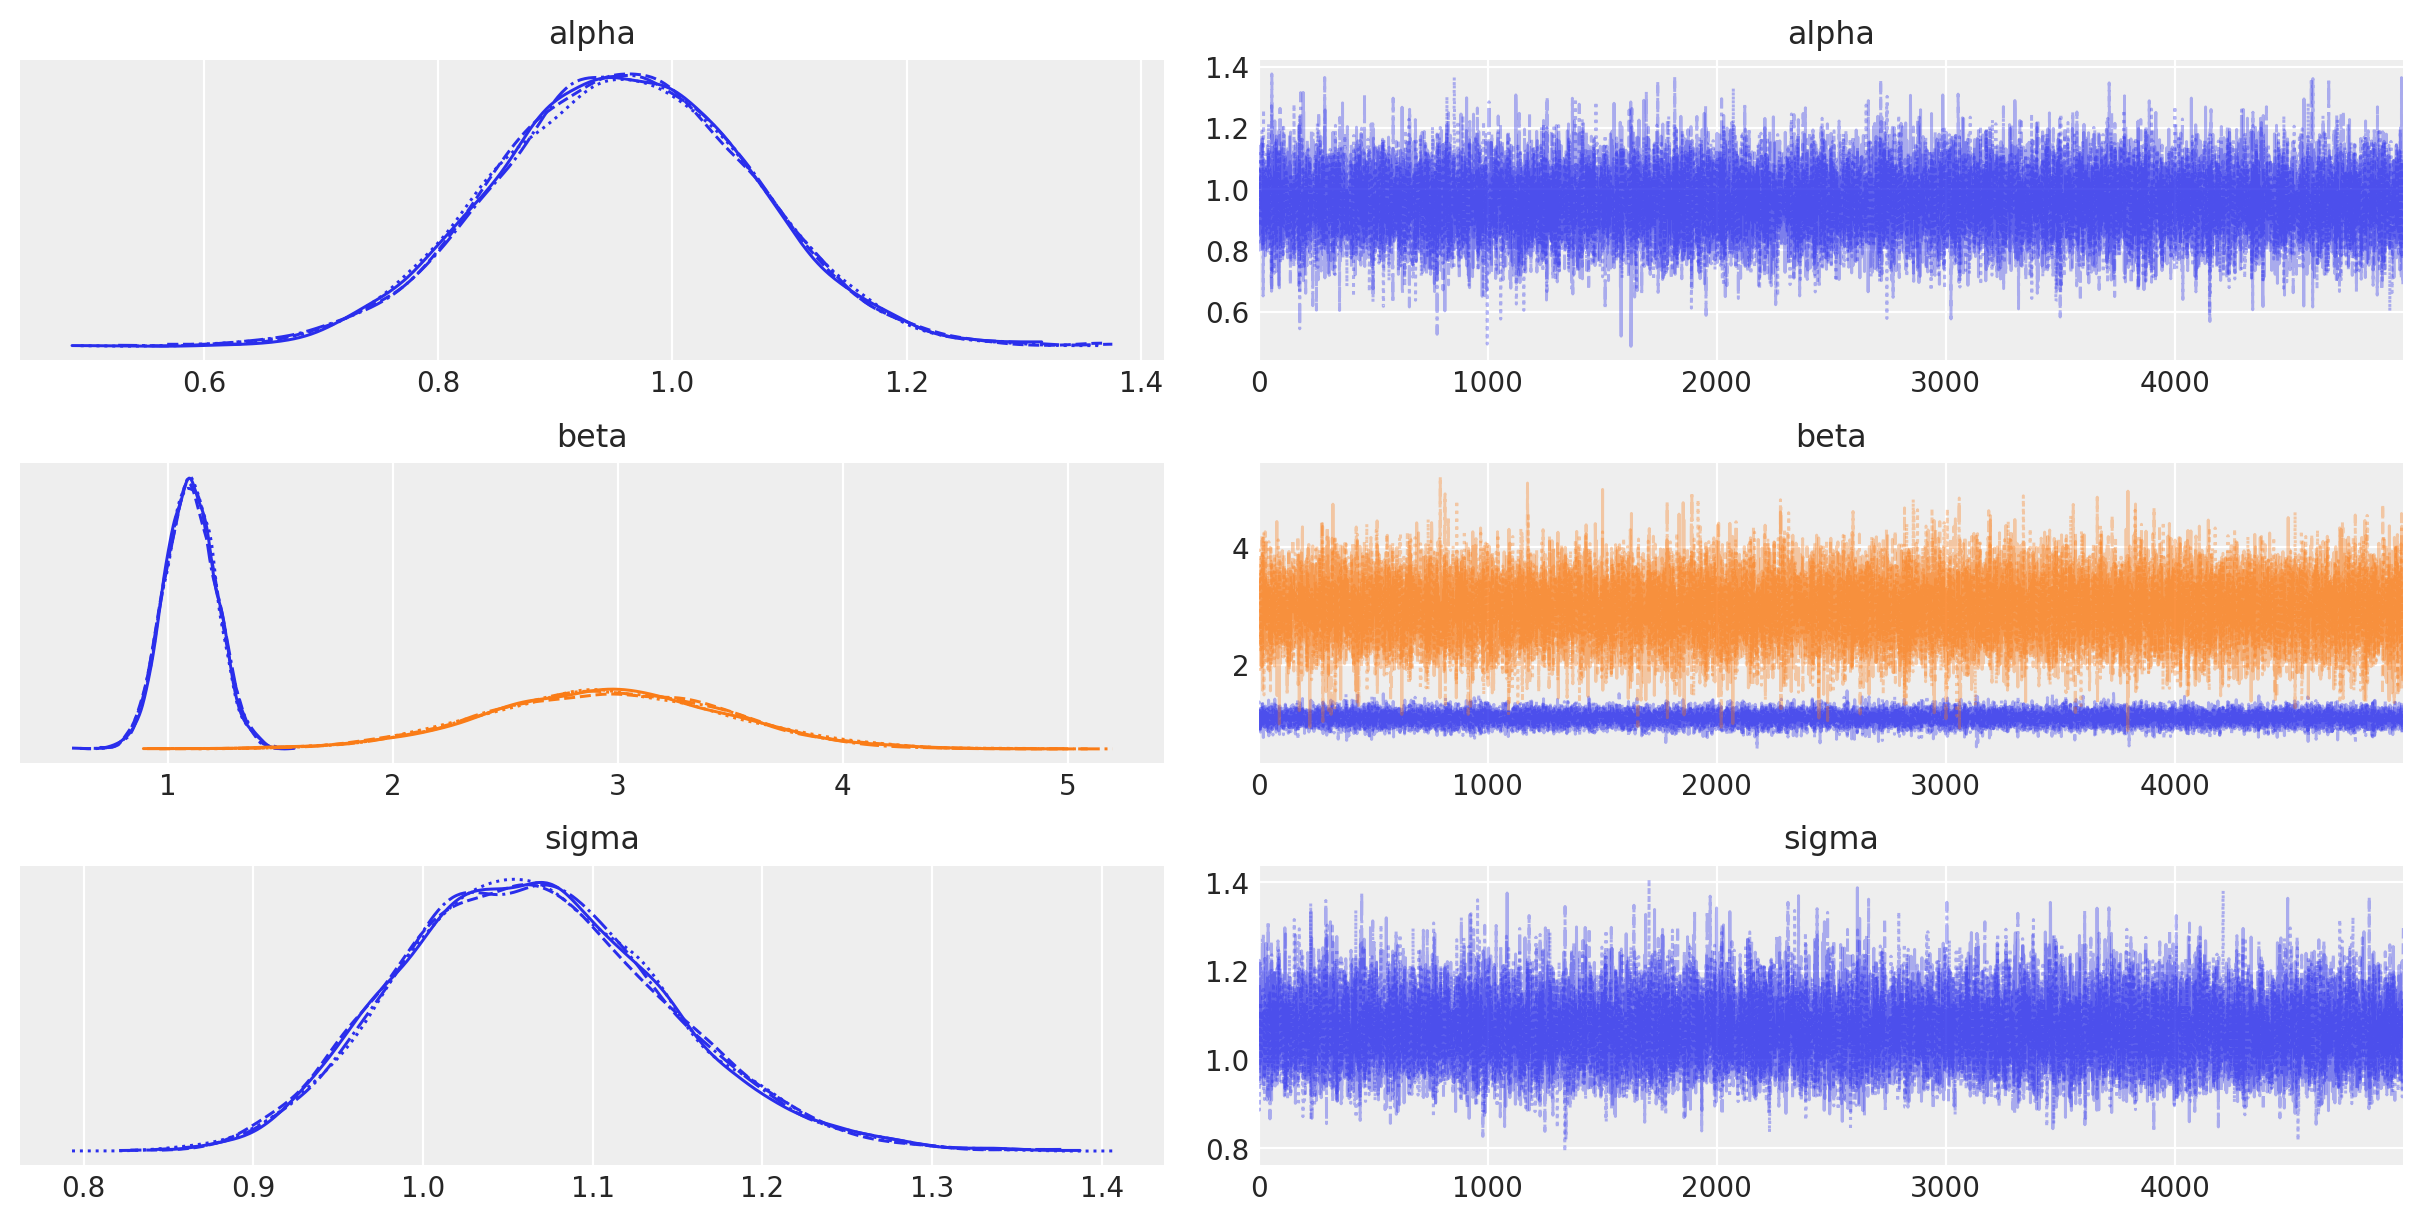

In [56]:
with basic_model:
    az.plot_trace(trace);

